In [97]:
import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
import sys

sys.path.insert(1, str(Path().cwd().parent))
import common_config

In [98]:
common_config.figure_journal_basic()

In [99]:
import pertpy as pt
import scanpy as sc
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [100]:
adata = sc.read_h5ad("data/zhang_preprocessed.h5ad")
adata

AnnData object with n_obs × n_vars = 150504 × 4000
    obs: 'Sample', 'Patient', 'Origin', 'Tissue', 'Efficacy', 'Group', 'Treatment', 'Number of counts', 'Number of genes', 'Major celltype', 'Cluster'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'Cluster_colors', 'Efficacy_colors', 'Group_colors', 'Major celltype_colors', 'Treatment_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [101]:
adata.obs["Group"].value_counts()

Group
Pre-treatment     89219
Post-treatment    61285
Name: count, dtype: int64

In [102]:
adata.obs["Timepoint"] = adata.obs["Group"].copy()
adata.obs["Group"] = [f"{timepoint.split('-')[0]}-{response}" for timepoint, response in zip(adata.obs["Timepoint"], adata.obs["Efficacy"])]
adata.obs["Group"].value_counts()

Group
Pre-Partial response     57295
Pre-Stable disease       31924
Post-Stable disease      31626
Post-Partial response    29659
Name: count, dtype: int64

In [103]:
# Get reference cell type
sccoda_model = pt.tl.Sccoda()

sccoda_data = sccoda_model.load(
    adata,
    type="cell_level",
    generate_sample_level=True,
    cell_type_identifier="Cluster",
    sample_identifier="Sample",
    covariate_obs=["Group"],
)

sccoda_data = sccoda_model.prepare(
    sccoda_data,
    modality_key="coda",
    formula=f"Group",
    reference_cell_type="automatic",
    automatic_reference_absence_threshold=0.1,
)

💡 Automatic reference selection! Reference cell type set to t_mono-FCN1
💡 Zero counts encountered in data! Added a pseudocount of 0.5.


In [104]:
def filter_data(adata_temp):
    isecs = pd.crosstab(adata_temp.obs["Cluster"], adata_temp.obs["Group"])
    celltypes = isecs[(isecs >0).all(axis=1)].index.values.tolist()
    adata_temp = adata_temp[adata_temp.obs["Cluster"].isin(celltypes)]
    return adata_temp

In [105]:
adata_chemo = adata[adata.obs["Treatment"] == "Chemo"]
adata_chemo = filter_data(adata_chemo)
adata_chemo.obs["Group"].value_counts()

Group
Post-Stable disease      20659
Pre-Partial response     16827
Post-Partial response    12137
Pre-Stable disease       11807
Name: count, dtype: int64

In [106]:
adata_chemo_pdl1 = adata[adata.obs["Treatment"] == "Anti-PD-L1+Chemo"]
adata_chemo_pdl1 = filter_data(adata_chemo_pdl1)
adata_chemo_pdl1.obs["Group"].value_counts()

Group
Pre-Partial response     40251
Post-Partial response    16379
Pre-Stable disease       13435
Post-Stable disease      10717
Name: count, dtype: int64

# Run scCODA

In [118]:
sccoda_model = pt.tl.Sccoda()
    
def run_sccoda(subset, condition, reference, plot=False):
    sccoda_data = sccoda_model.load(
        subset,
        type="cell_level",
        generate_sample_level=True,
        cell_type_identifier="Cluster",
        sample_identifier="Sample",
        covariate_obs=["Group"],
    )
    
    if plot:
        sccoda_model.plot_boxplots(
            sccoda_data,
            modality_key="coda",
            feature_name="Group",
            add_dots=True,
        )
        fig = plt.gcf()
        fig.set_size_inches(15, 5)
        plt.savefig(f"figures/compositional_boxplot_{condition}_umap.png", bbox_inches="tight")

    sccoda_data = sccoda_model.prepare(
        sccoda_data,
        modality_key="coda",
        formula=f"C(Group, Treatment('{reference}'))",
        reference_cell_type="t_mono-FCN1", #"automatic",
        automatic_reference_absence_threshold=0.1,
    )

    sccoda_model.run_nuts(sccoda_data, modality_key="coda")
    sccoda_model.set_fdr(sccoda_data, modality_key="coda", est_fdr=0.05)
    #sccoda_model.summary(sccoda_data, modality_key="coda")
    
    comparison_groups = [g for g in subset.obs["Group"].unique() if g != reference]
    effect_df = pd.DataFrame({"log2-fold change": [], "Cell Type": [], "Reference": [], "Comp. Group": [], "Final Parameter": []})
    for comp_group in comparison_groups:    
        group_effects = sccoda_data["coda"].varm[f"effect_df_C(Group, Treatment('{reference}'))[T.{comp_group}]"][["log2-fold change", "Final Parameter"]]
        group_effects = group_effects[group_effects["Final Parameter"] != 0]
        group_effects["Cell Type"] = group_effects.index
        group_effects["Reference"] = reference
        group_effects["Comp. Group"] = comp_group
        effect_df = pd.concat([effect_df, group_effects])
    
    return effect_df

Pre-Stable disease
💡 Zero counts encountered in data! Added a pseudocount of 0.5.


sample: 100%|██████████| 11000/11000 [02:12<00:00, 83.26it/s, 127 steps of size 2.63e-02. acc. prob=0.89]


Pre-Partial response
💡 Zero counts encountered in data! Added a pseudocount of 0.5.


sample: 100%|██████████| 11000/11000 [02:09<00:00, 85.20it/s, 127 steps of size 3.40e-02. acc. prob=0.85]


Post-Stable disease
💡 Zero counts encountered in data! Added a pseudocount of 0.5.


sample: 100%|██████████| 11000/11000 [01:56<00:00, 94.67it/s, 127 steps of size 2.78e-02. acc. prob=0.87] 


Post-Partial response
💡 Zero counts encountered in data! Added a pseudocount of 0.5.


sample: 100%|██████████| 11000/11000 [02:10<00:00, 84.04it/s, 127 steps of size 3.30e-02. acc. prob=0.79]


log2-fold change       Cell Type              Reference  \
t_CD4_Tcm-LMNA         -1.176516  t_CD4_Tcm-LMNA     Pre-Stable disease   
t_CD8_Tem-GZMK         -1.298329  t_CD8_Tem-GZMK     Pre-Stable disease   
t_CD4_Tcm-LMNA         -1.230962  t_CD4_Tcm-LMNA    Post-Stable disease   
t_CD8_Tem-GZMK         -1.375092  t_CD8_Tem-GZMK    Post-Stable disease   
t_CD4_Tcm-LMNA         -1.209557  t_CD4_Tcm-LMNA  Post-Partial response   
t_CD8_Tem-GZMK         -1.335905  t_CD8_Tem-GZMK  Post-Partial response   

                         Comp. Group  Final Parameter  
t_CD4_Tcm-LMNA  Pre-Partial response        -0.963443  
t_CD8_Tem-GZMK  Pre-Partial response        -1.047878  
t_CD4_Tcm-LMNA  Pre-Partial response        -1.012419  
t_CD8_Tem-GZMK  Pre-Partial response        -1.112323  
t_CD4_Tcm-LMNA  Pre-Partial response        -0.994157  
t_CD8_Tem-GZMK  Pre-Partial response        -1.081735

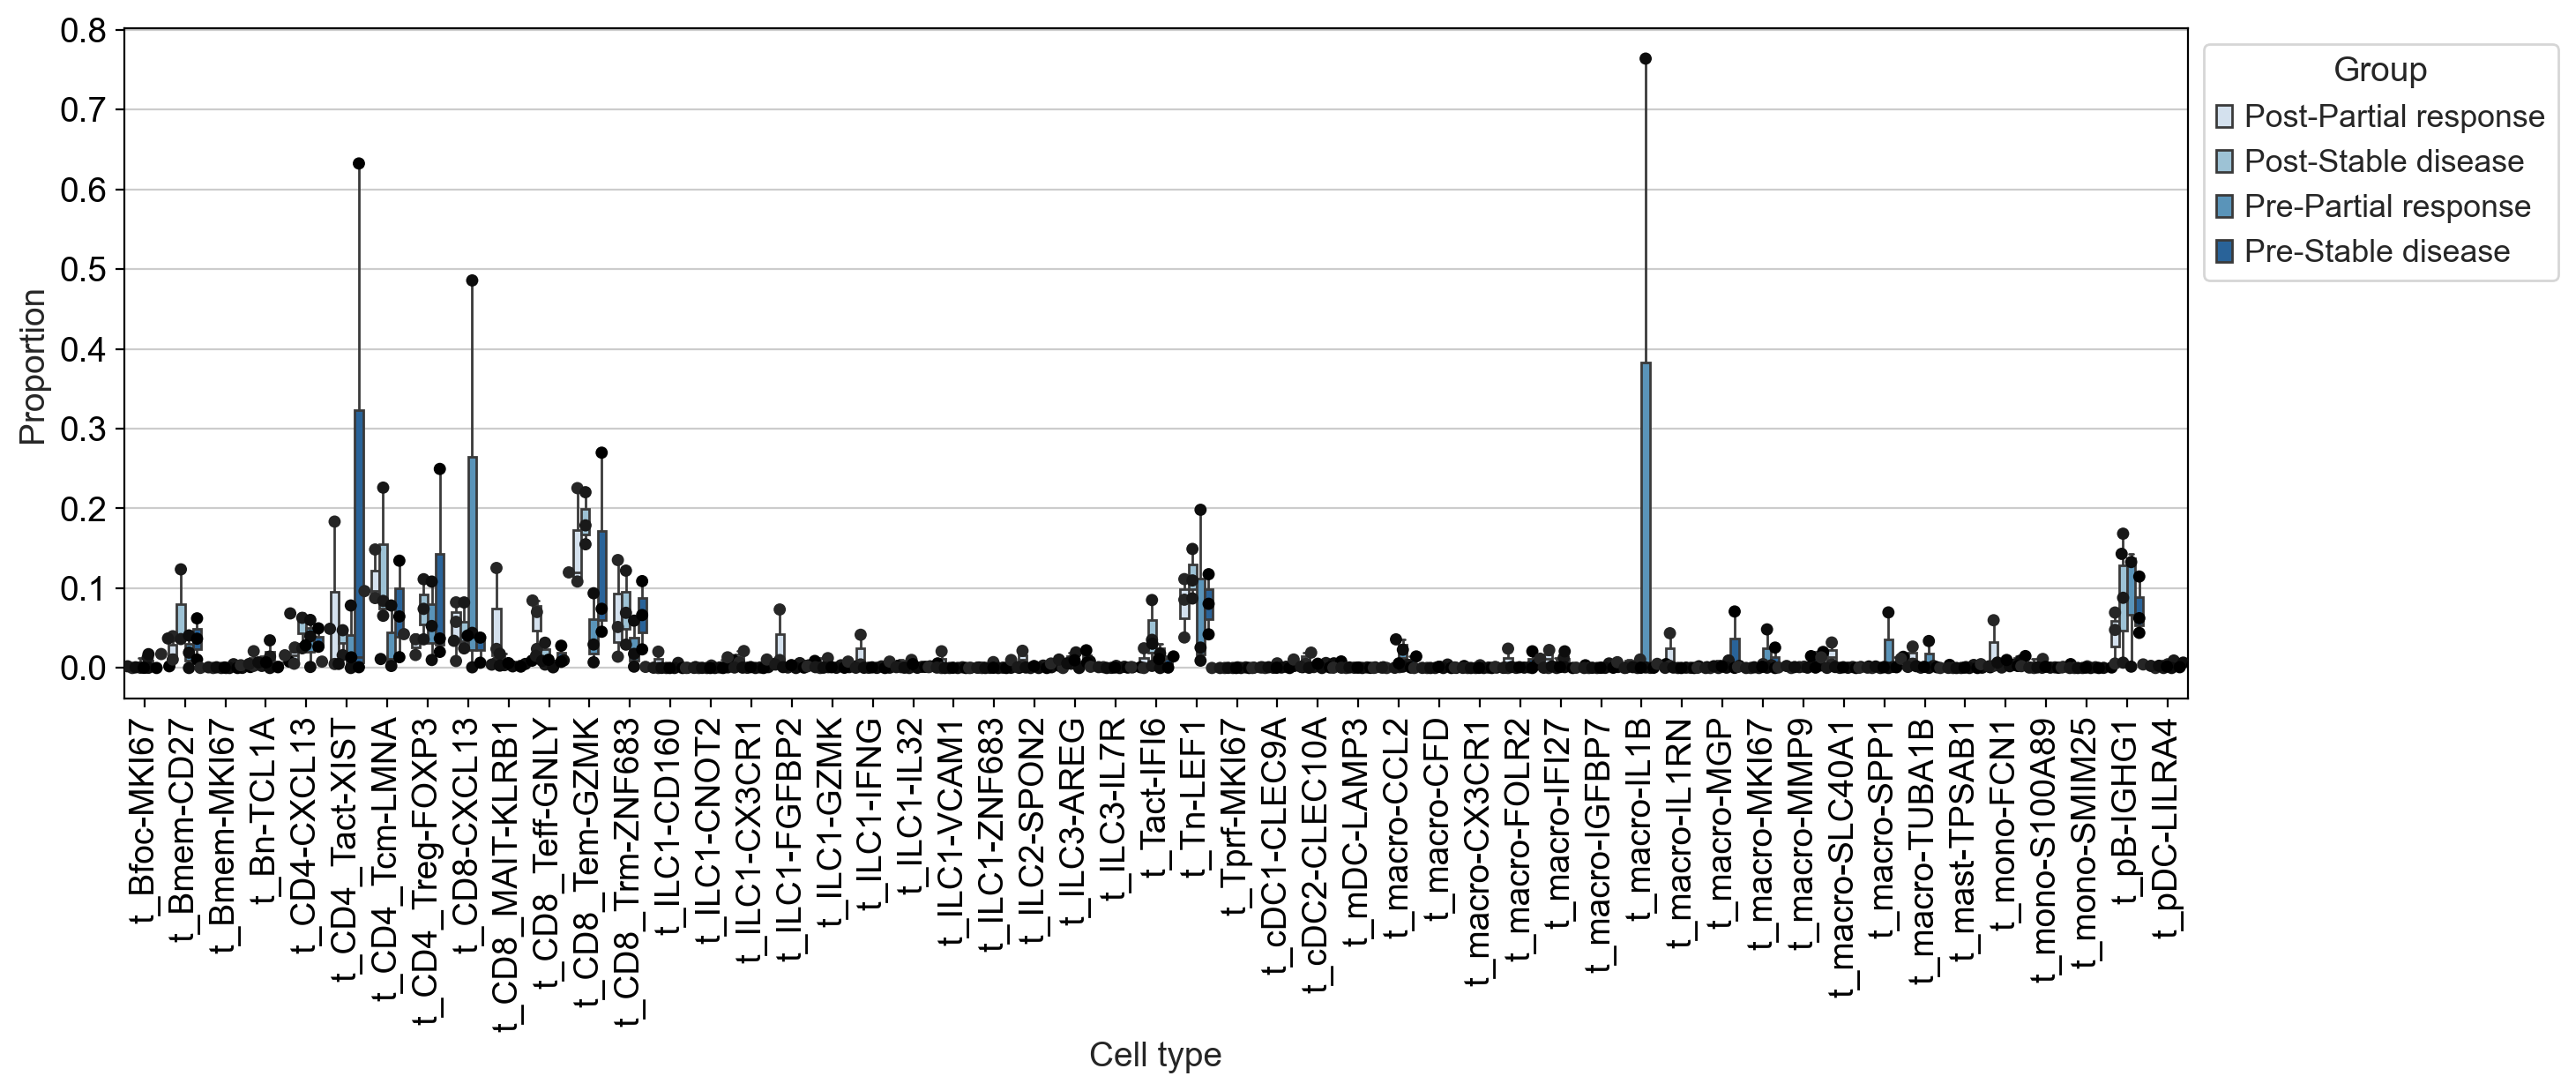

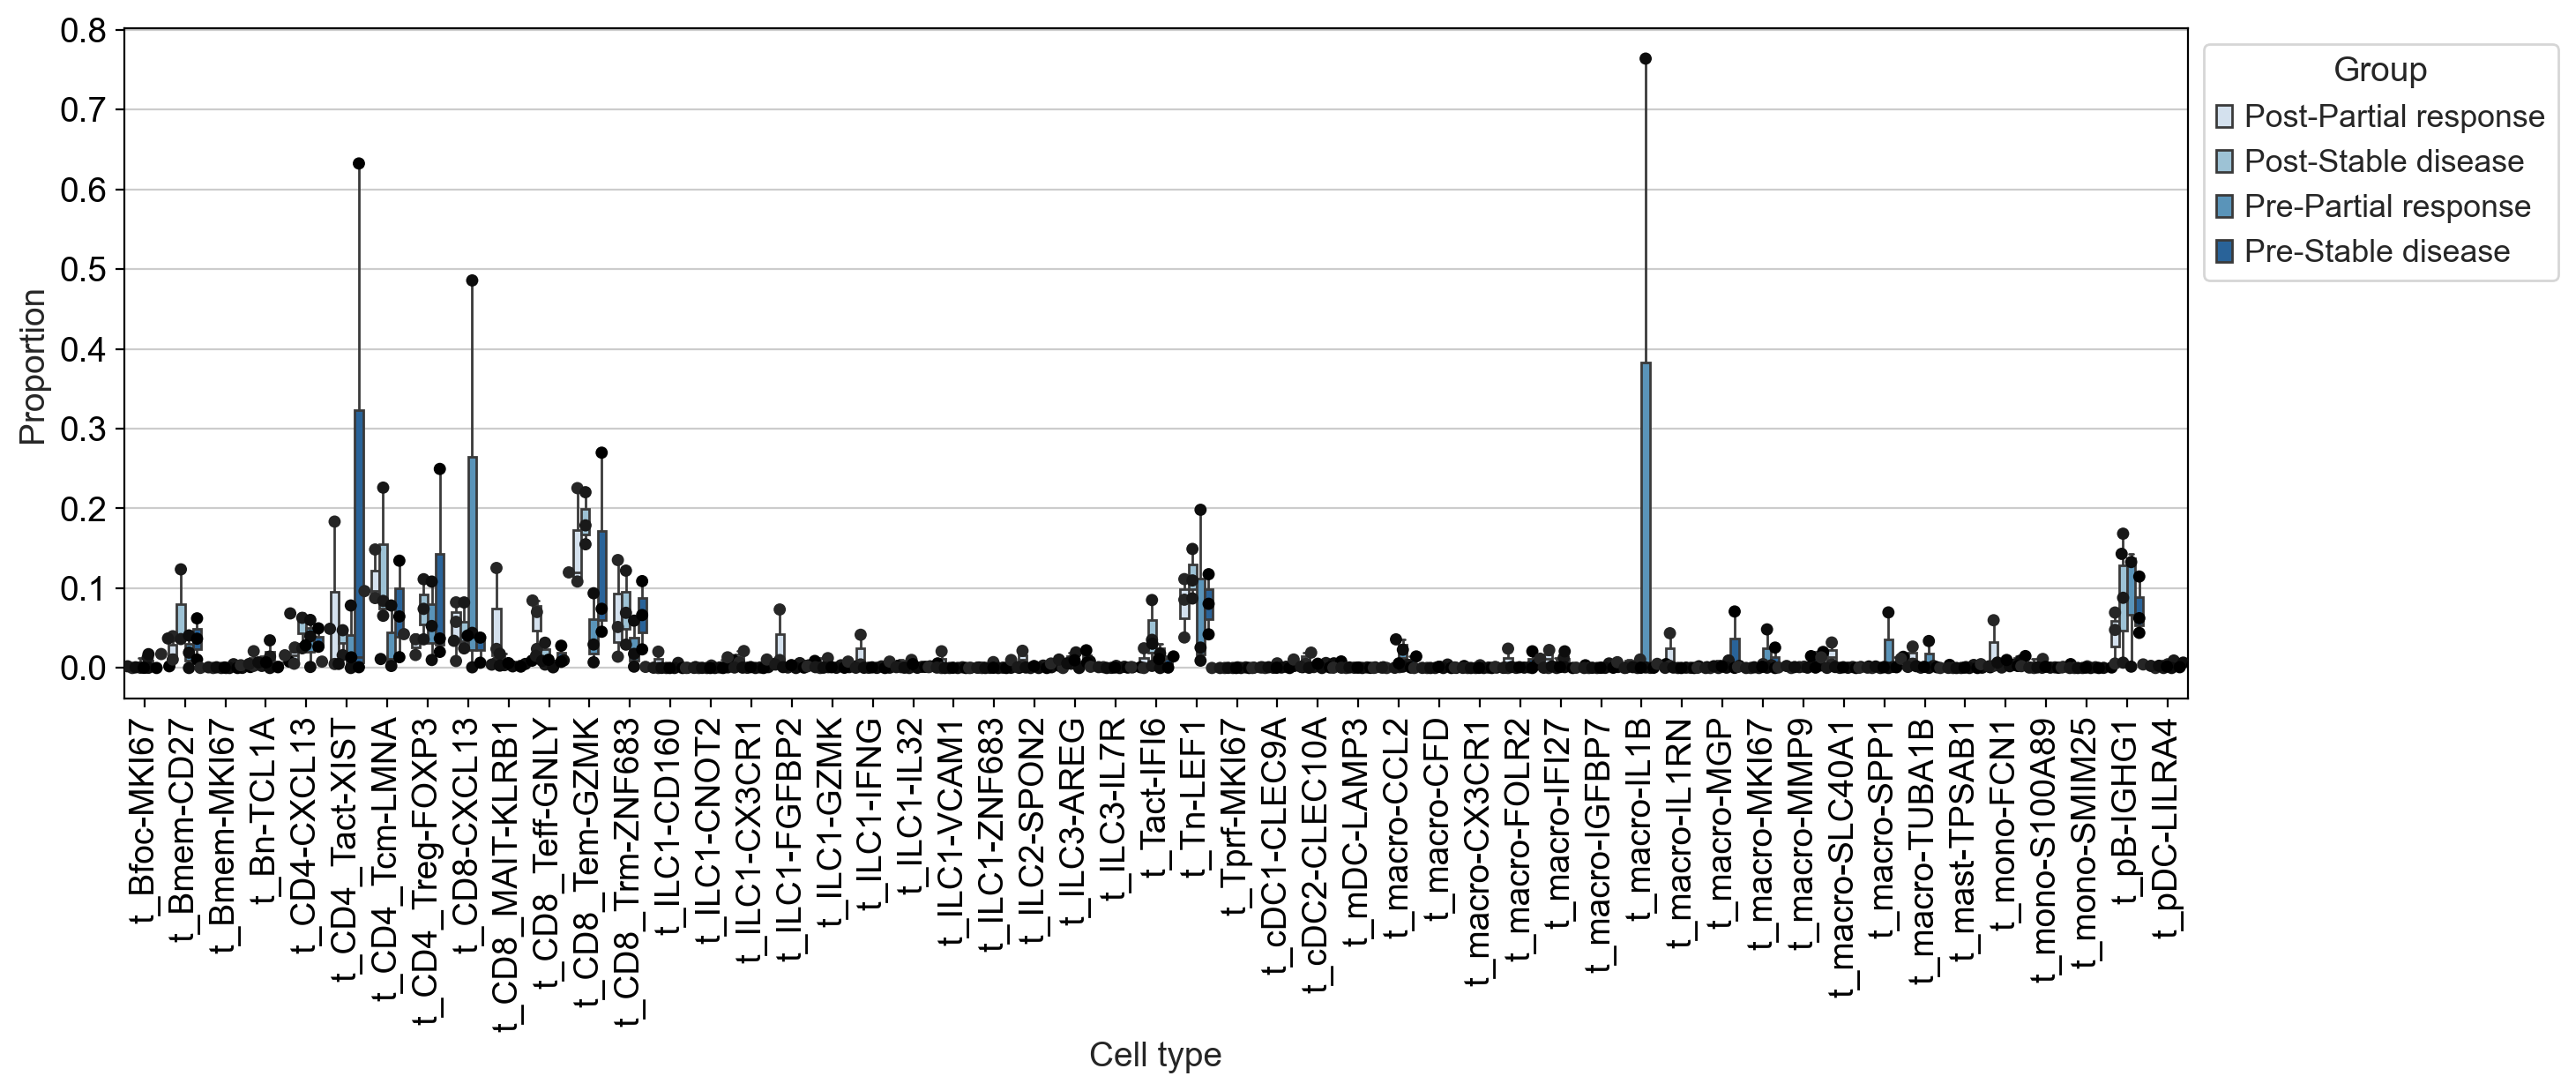

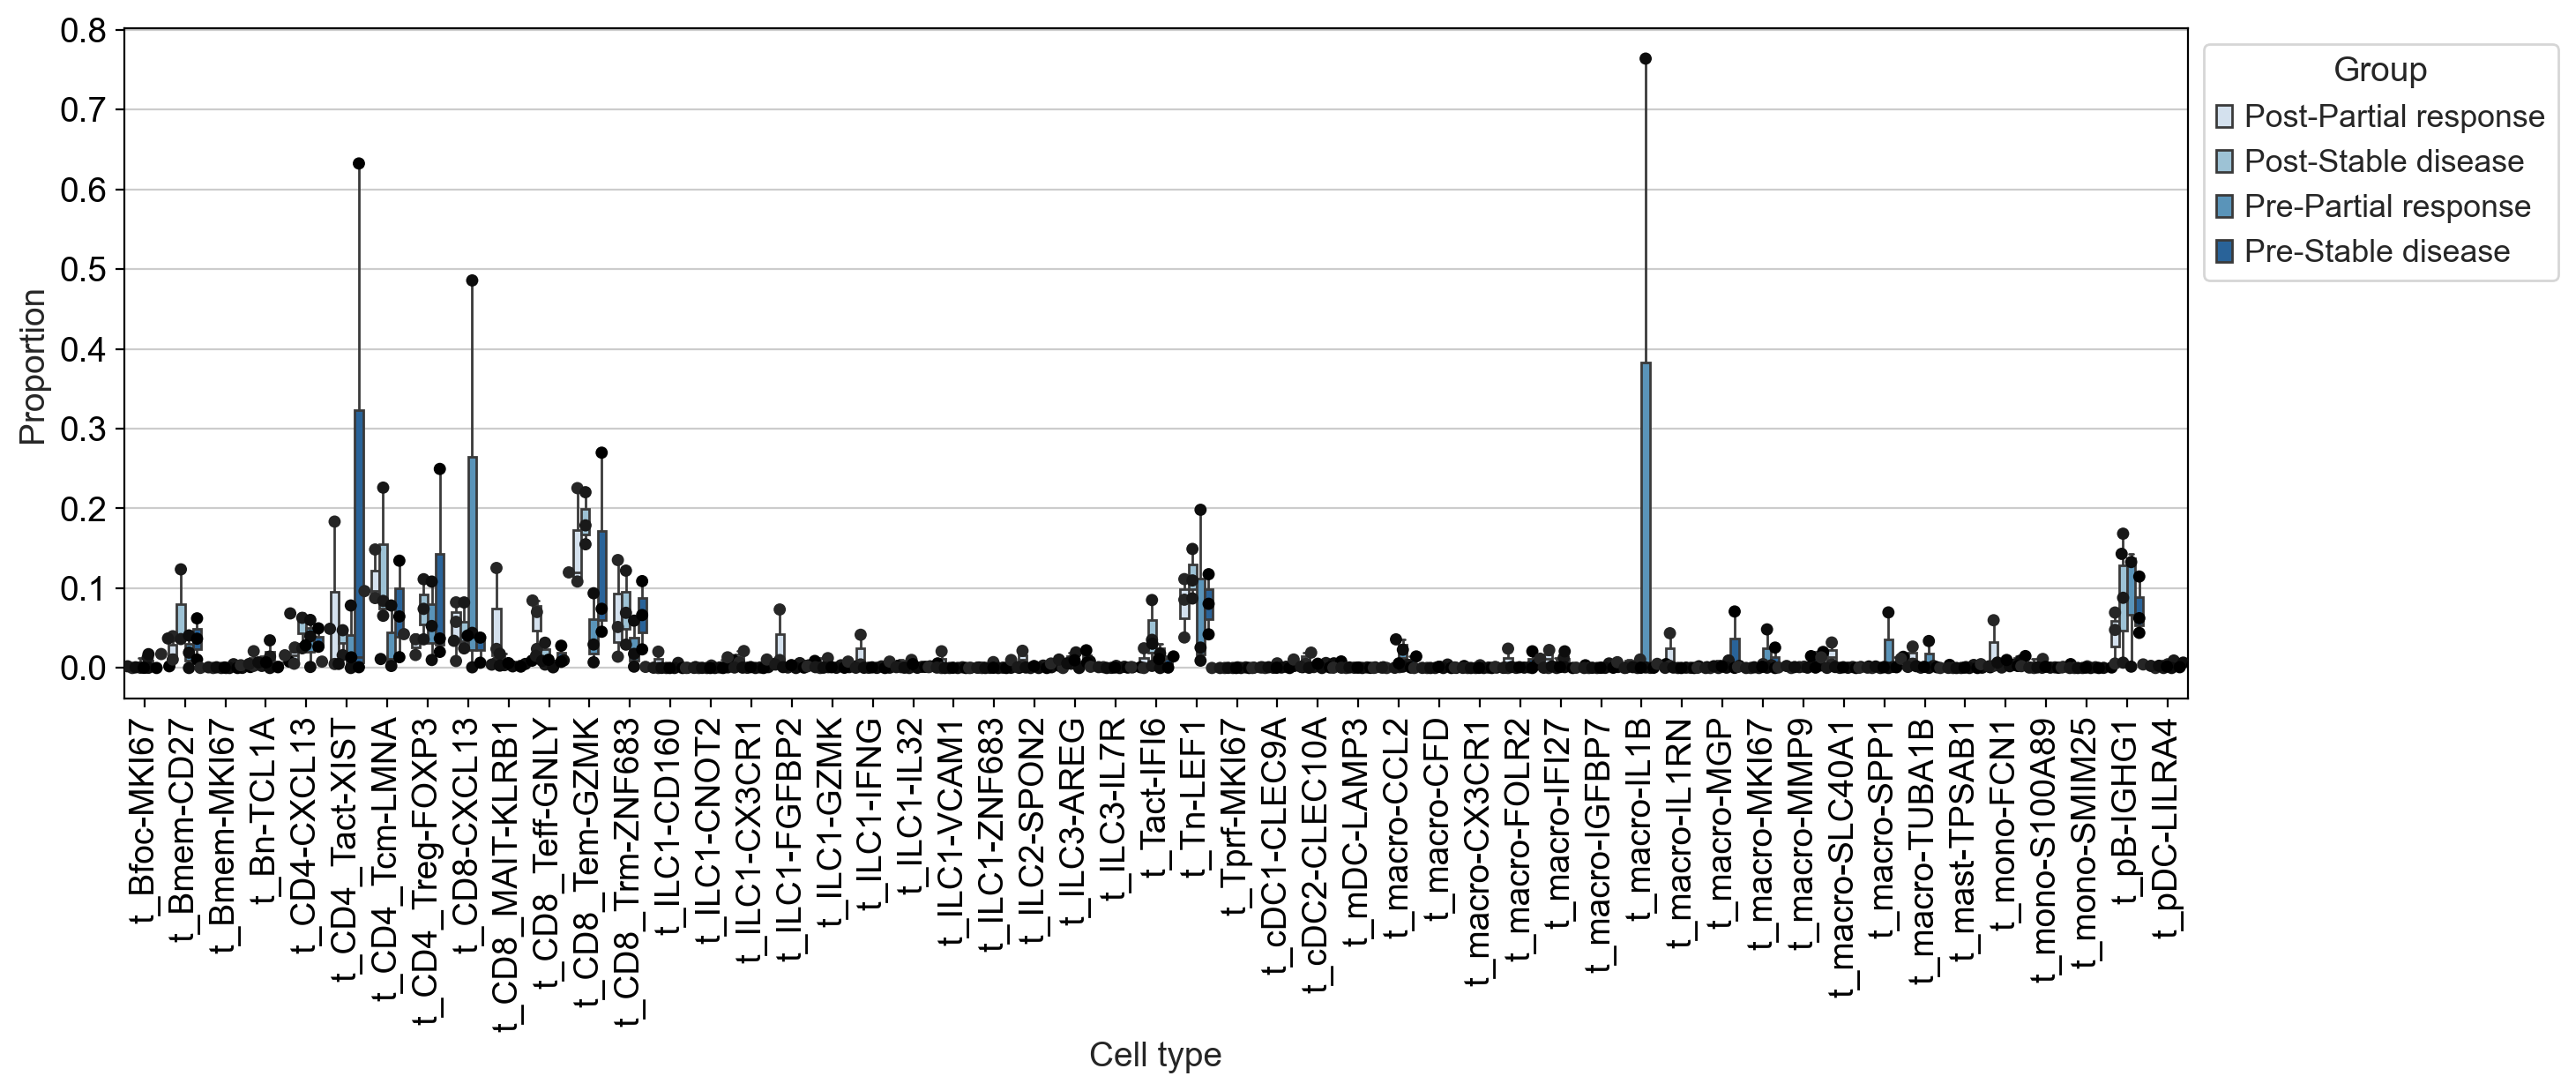

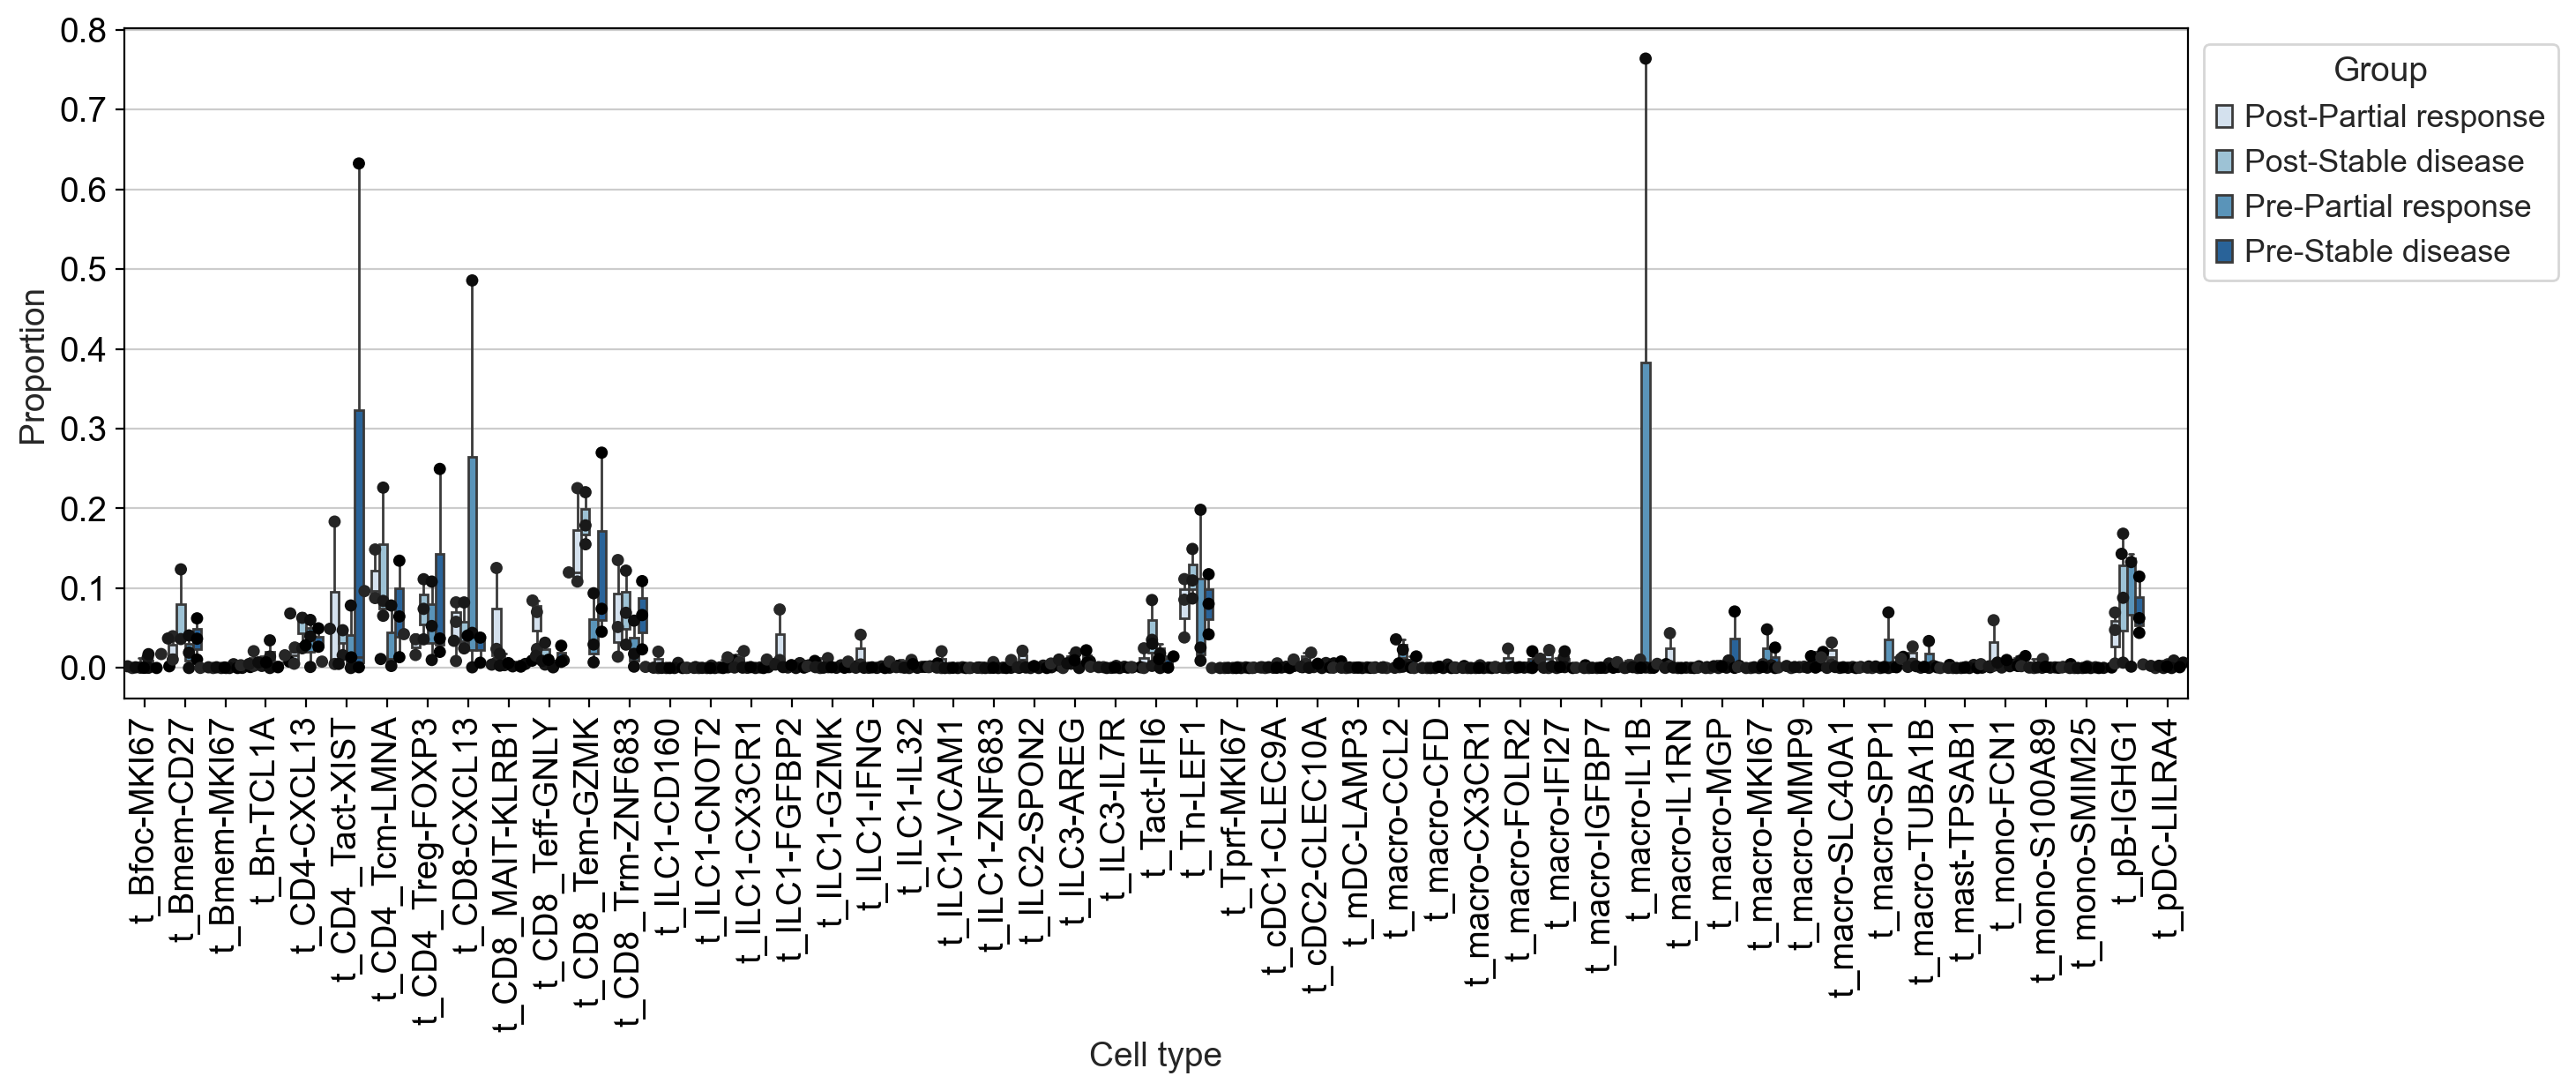

In [119]:
credible_effects_chemo = pd.DataFrame({"log2-fold change": [], "Cell Type": [], "Reference": [], "Comp. Group": [], "Final Parameter": []})

for reference in adata_chemo.obs["Group"].unique():
    print(reference)
    sccoda_chemo = run_sccoda(adata_chemo, condition="Chemo", reference=reference, plot=True)
    credible_effects_chemo = pd.concat([credible_effects_chemo, sccoda_chemo])
credible_effects_chemo

Pre-Partial response
💡 Zero counts encountered in data! Added a pseudocount of 0.5.


sample: 100%|██████████| 11000/11000 [02:02<00:00, 89.85it/s, 127 steps of size 4.46e-02. acc. prob=0.71]


Pre-Stable disease
💡 Zero counts encountered in data! Added a pseudocount of 0.5.


sample: 100%|██████████| 11000/11000 [02:05<00:00, 87.78it/s, 127 steps of size 3.73e-02. acc. prob=0.77]


Post-Partial response
💡 Zero counts encountered in data! Added a pseudocount of 0.5.


sample: 100%|██████████| 11000/11000 [02:11<00:00, 83.85it/s, 127 steps of size 3.12e-02. acc. prob=0.92]


Post-Stable disease
💡 Zero counts encountered in data! Added a pseudocount of 0.5.


sample: 100%|██████████| 11000/11000 [02:04<00:00, 88.55it/s, 127 steps of size 3.74e-02. acc. prob=0.75]


Empty DataFrame
Columns: [log2-fold change, Cell Type, Reference, Comp. Group, Final Parameter]
Index: []

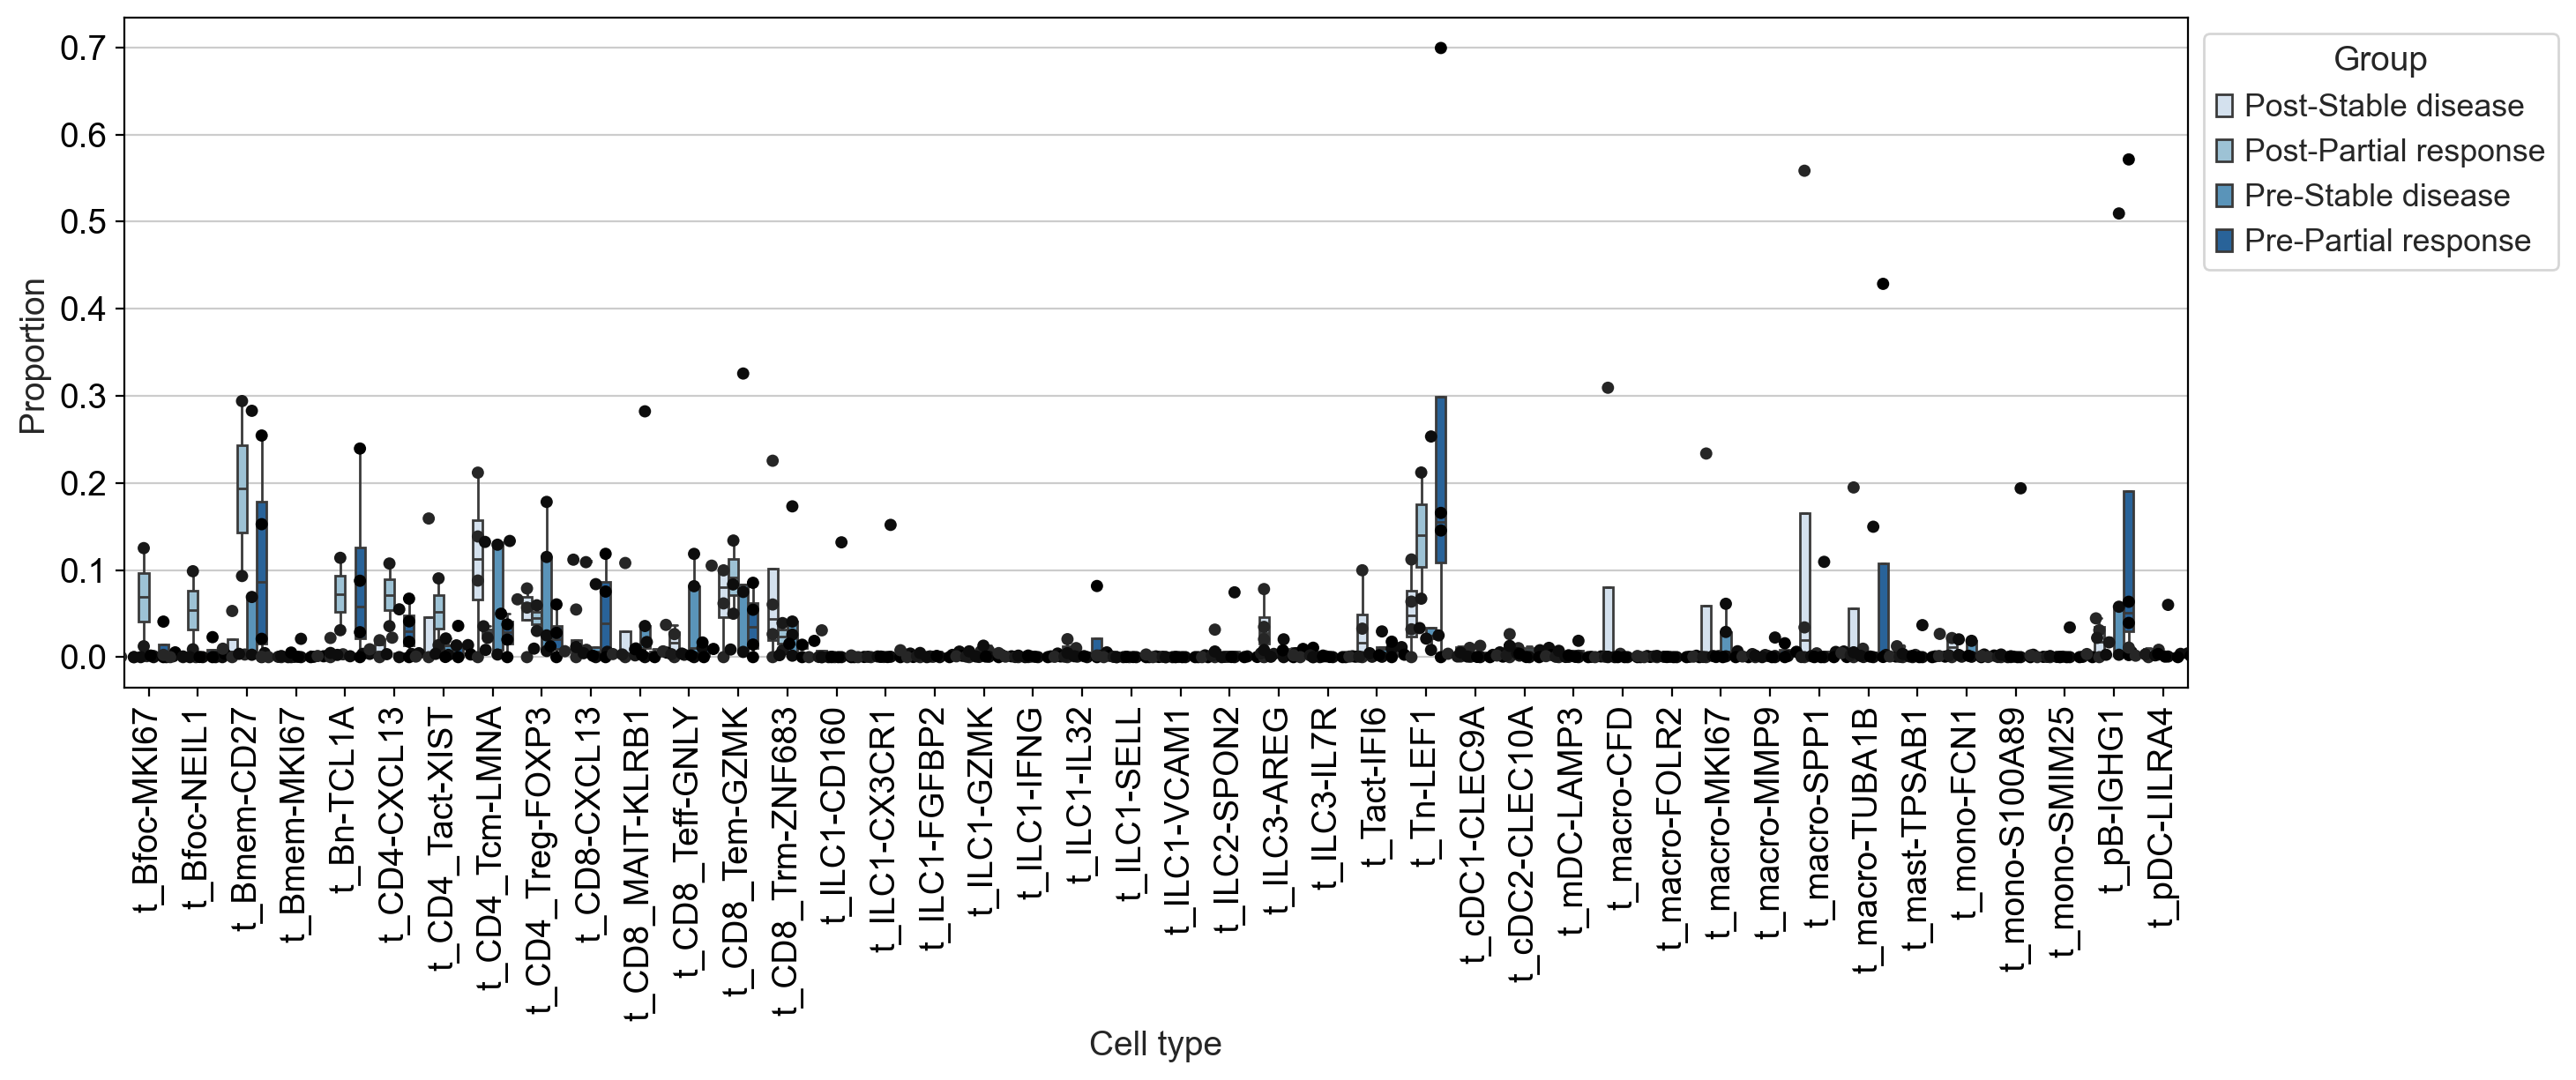

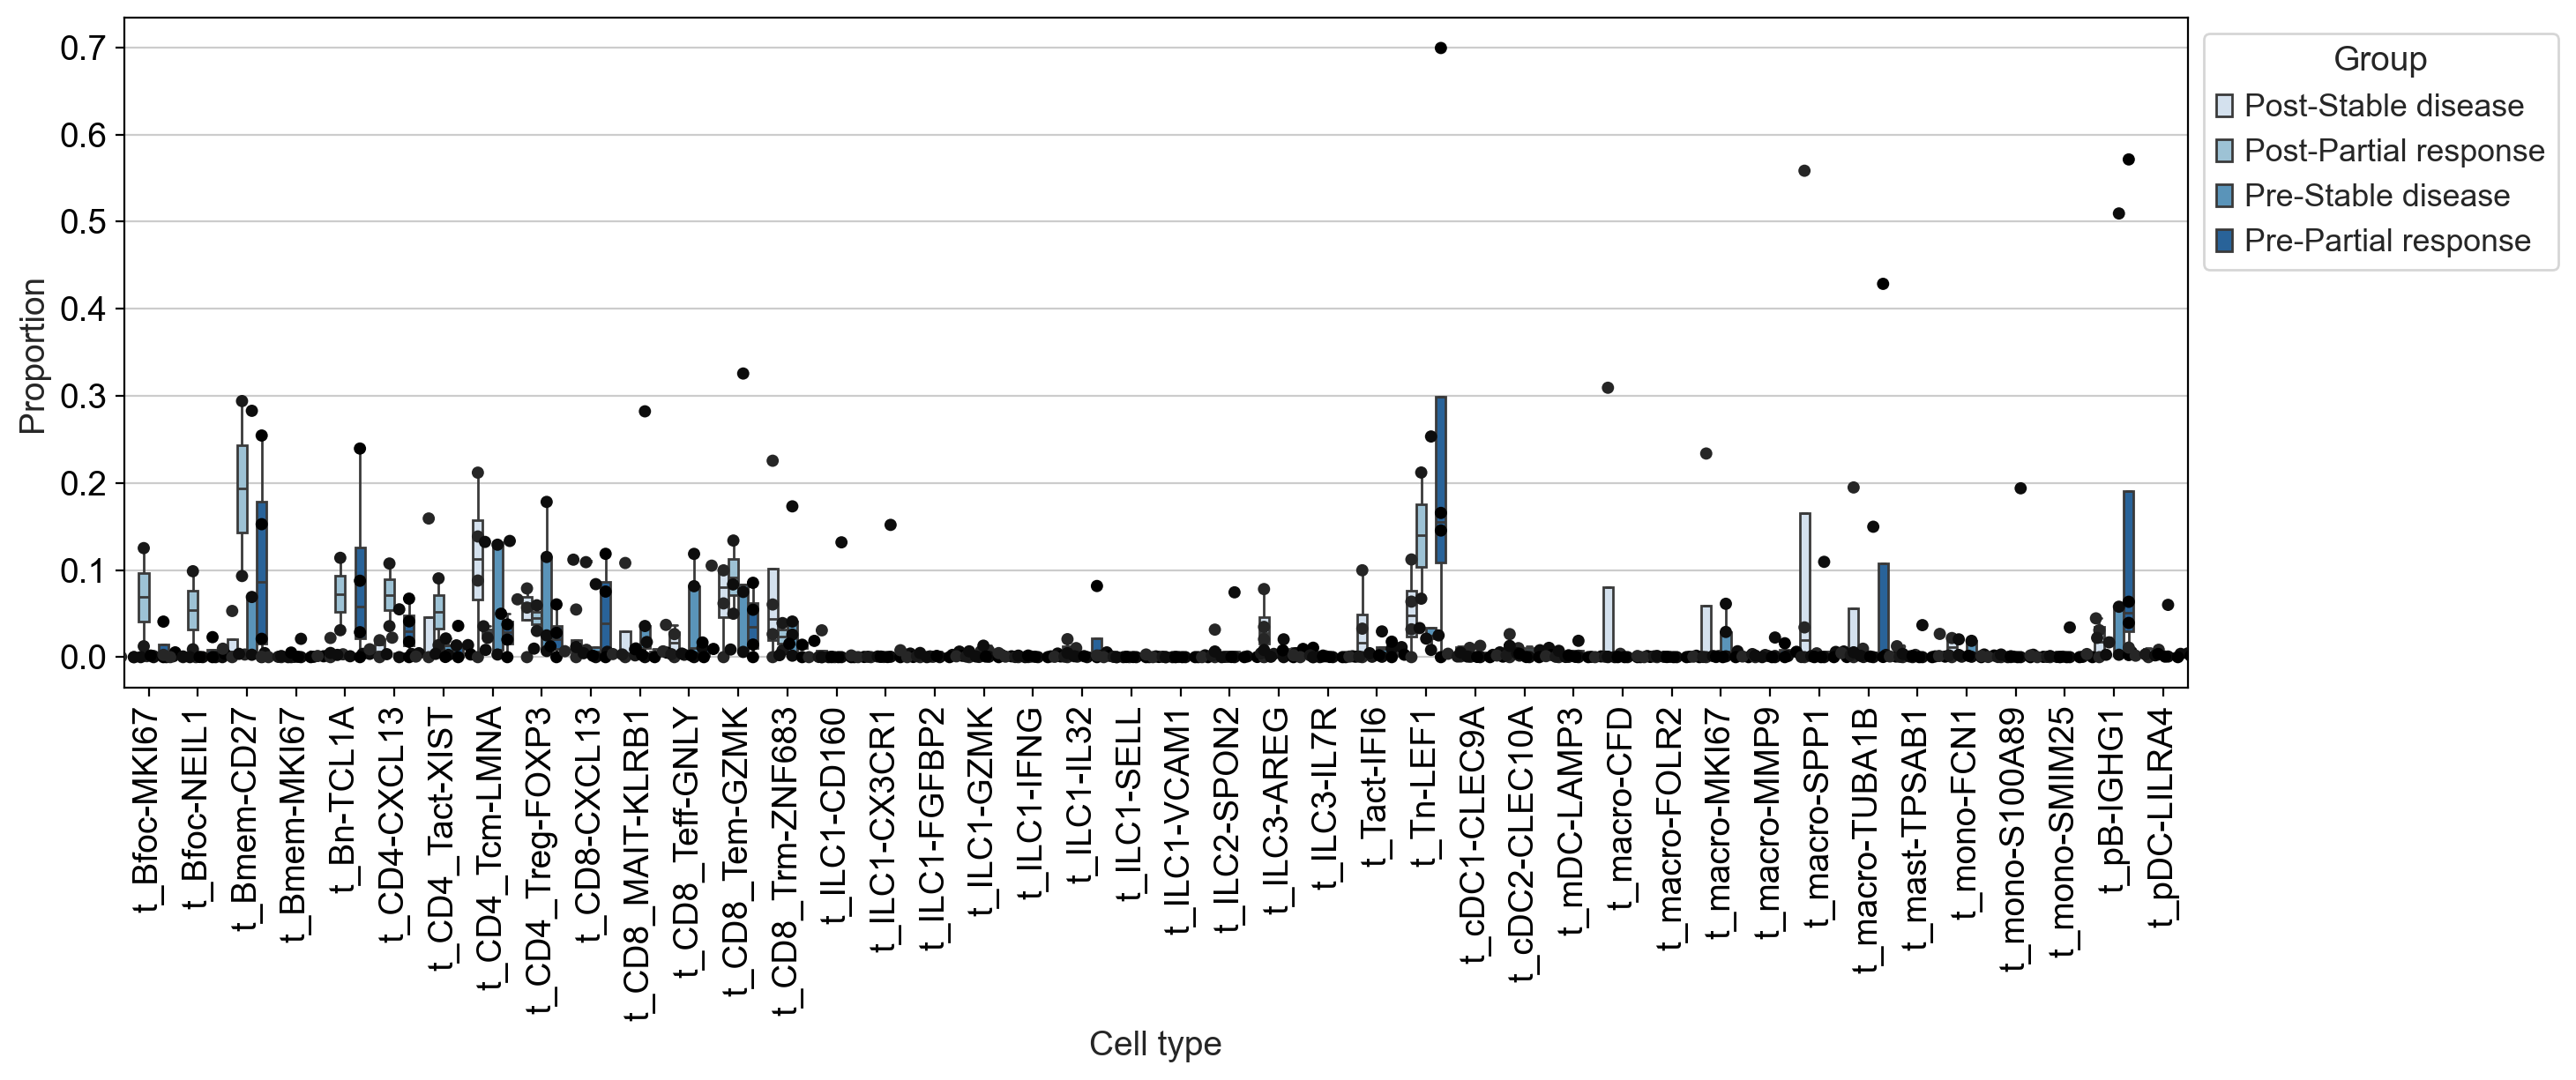

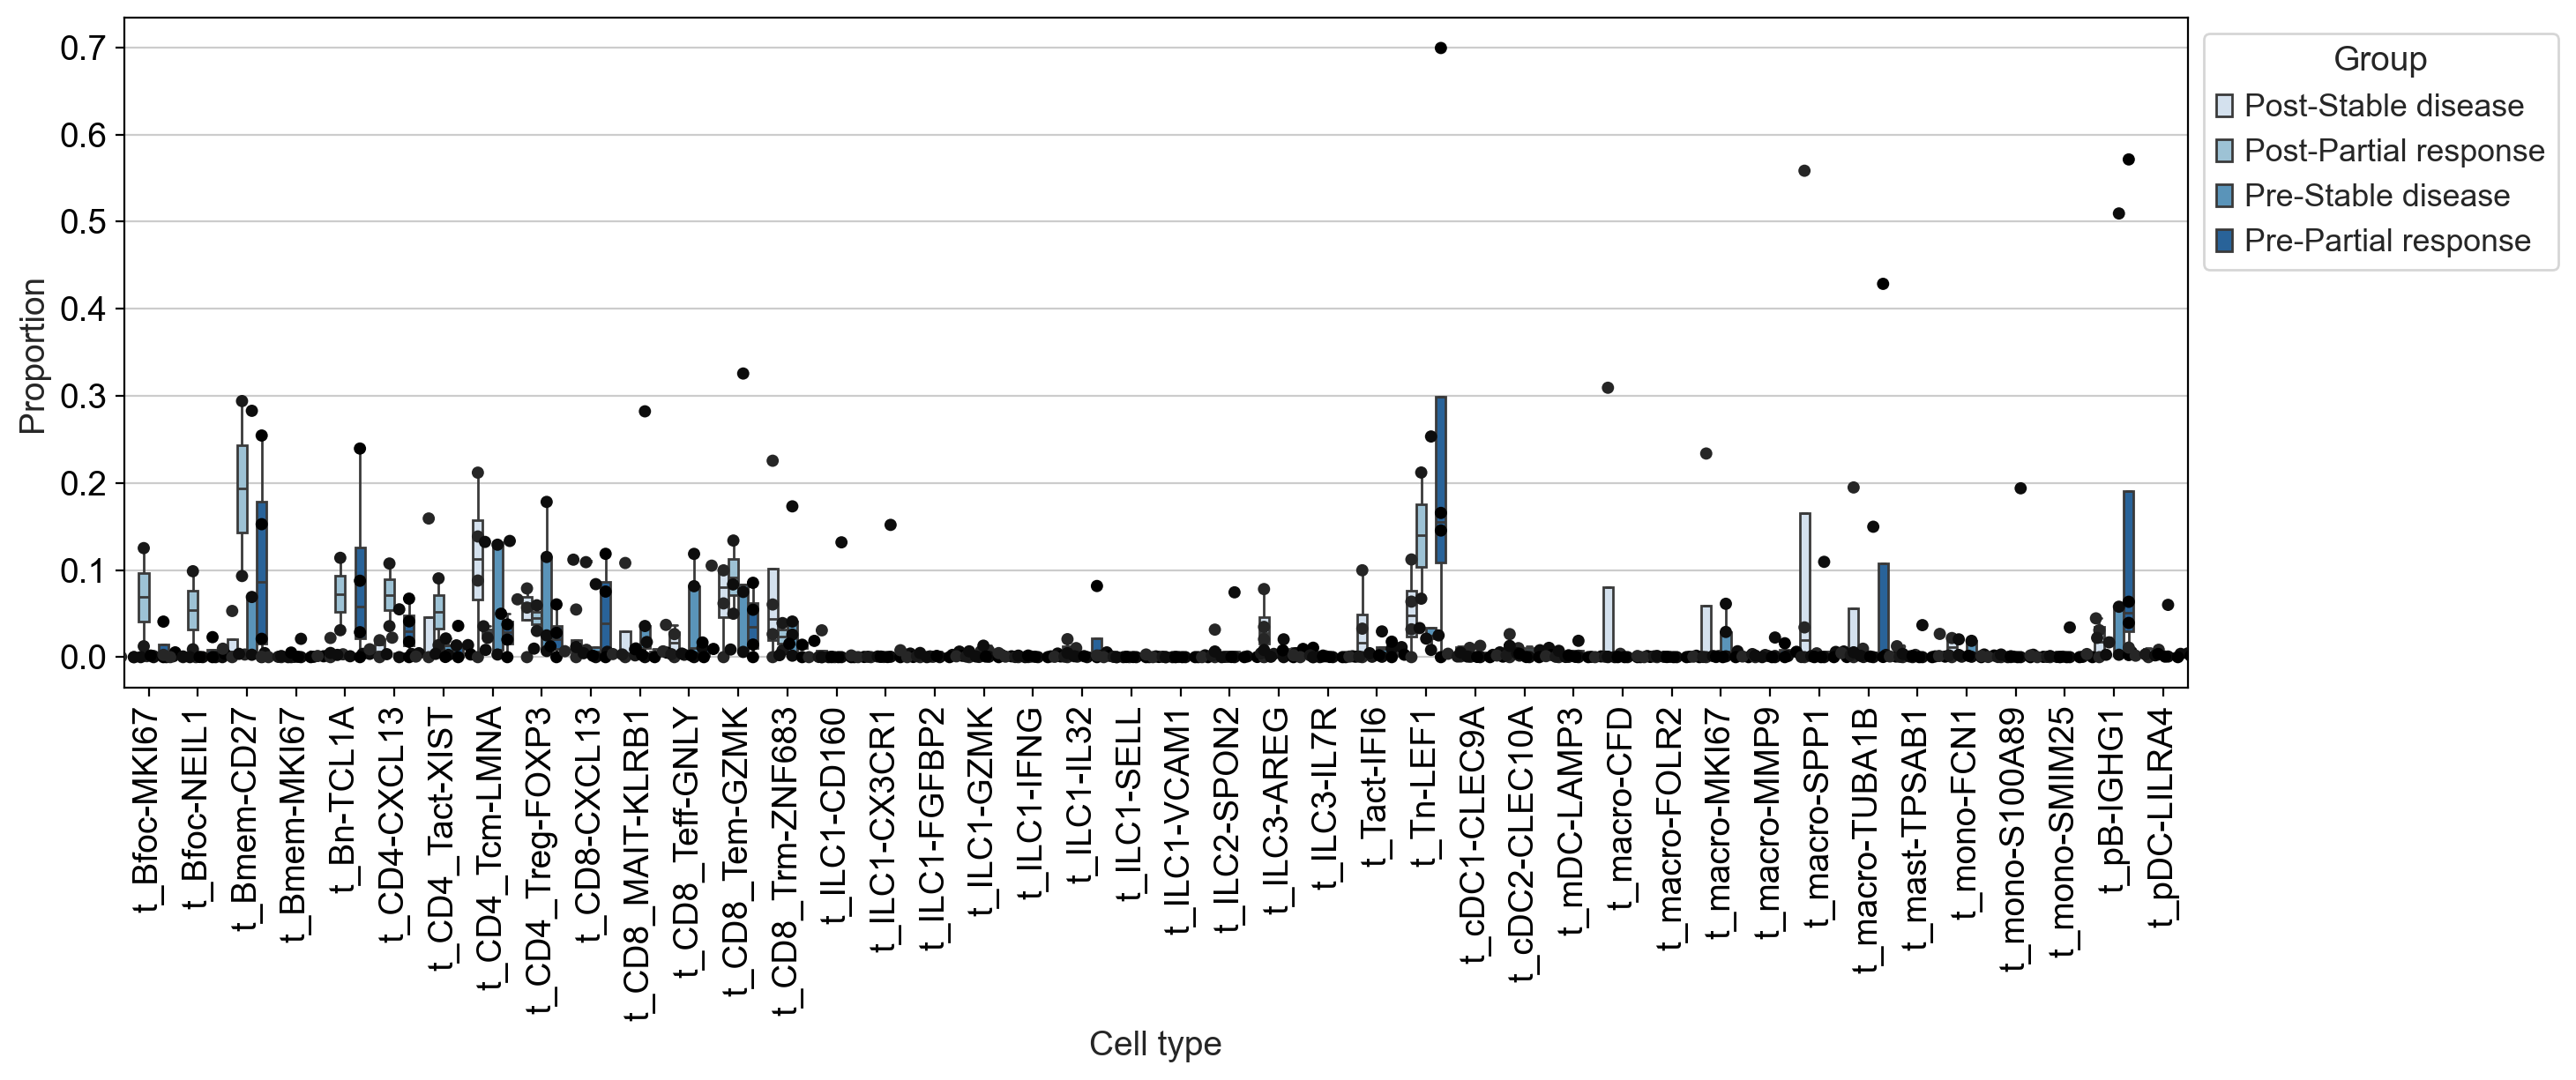

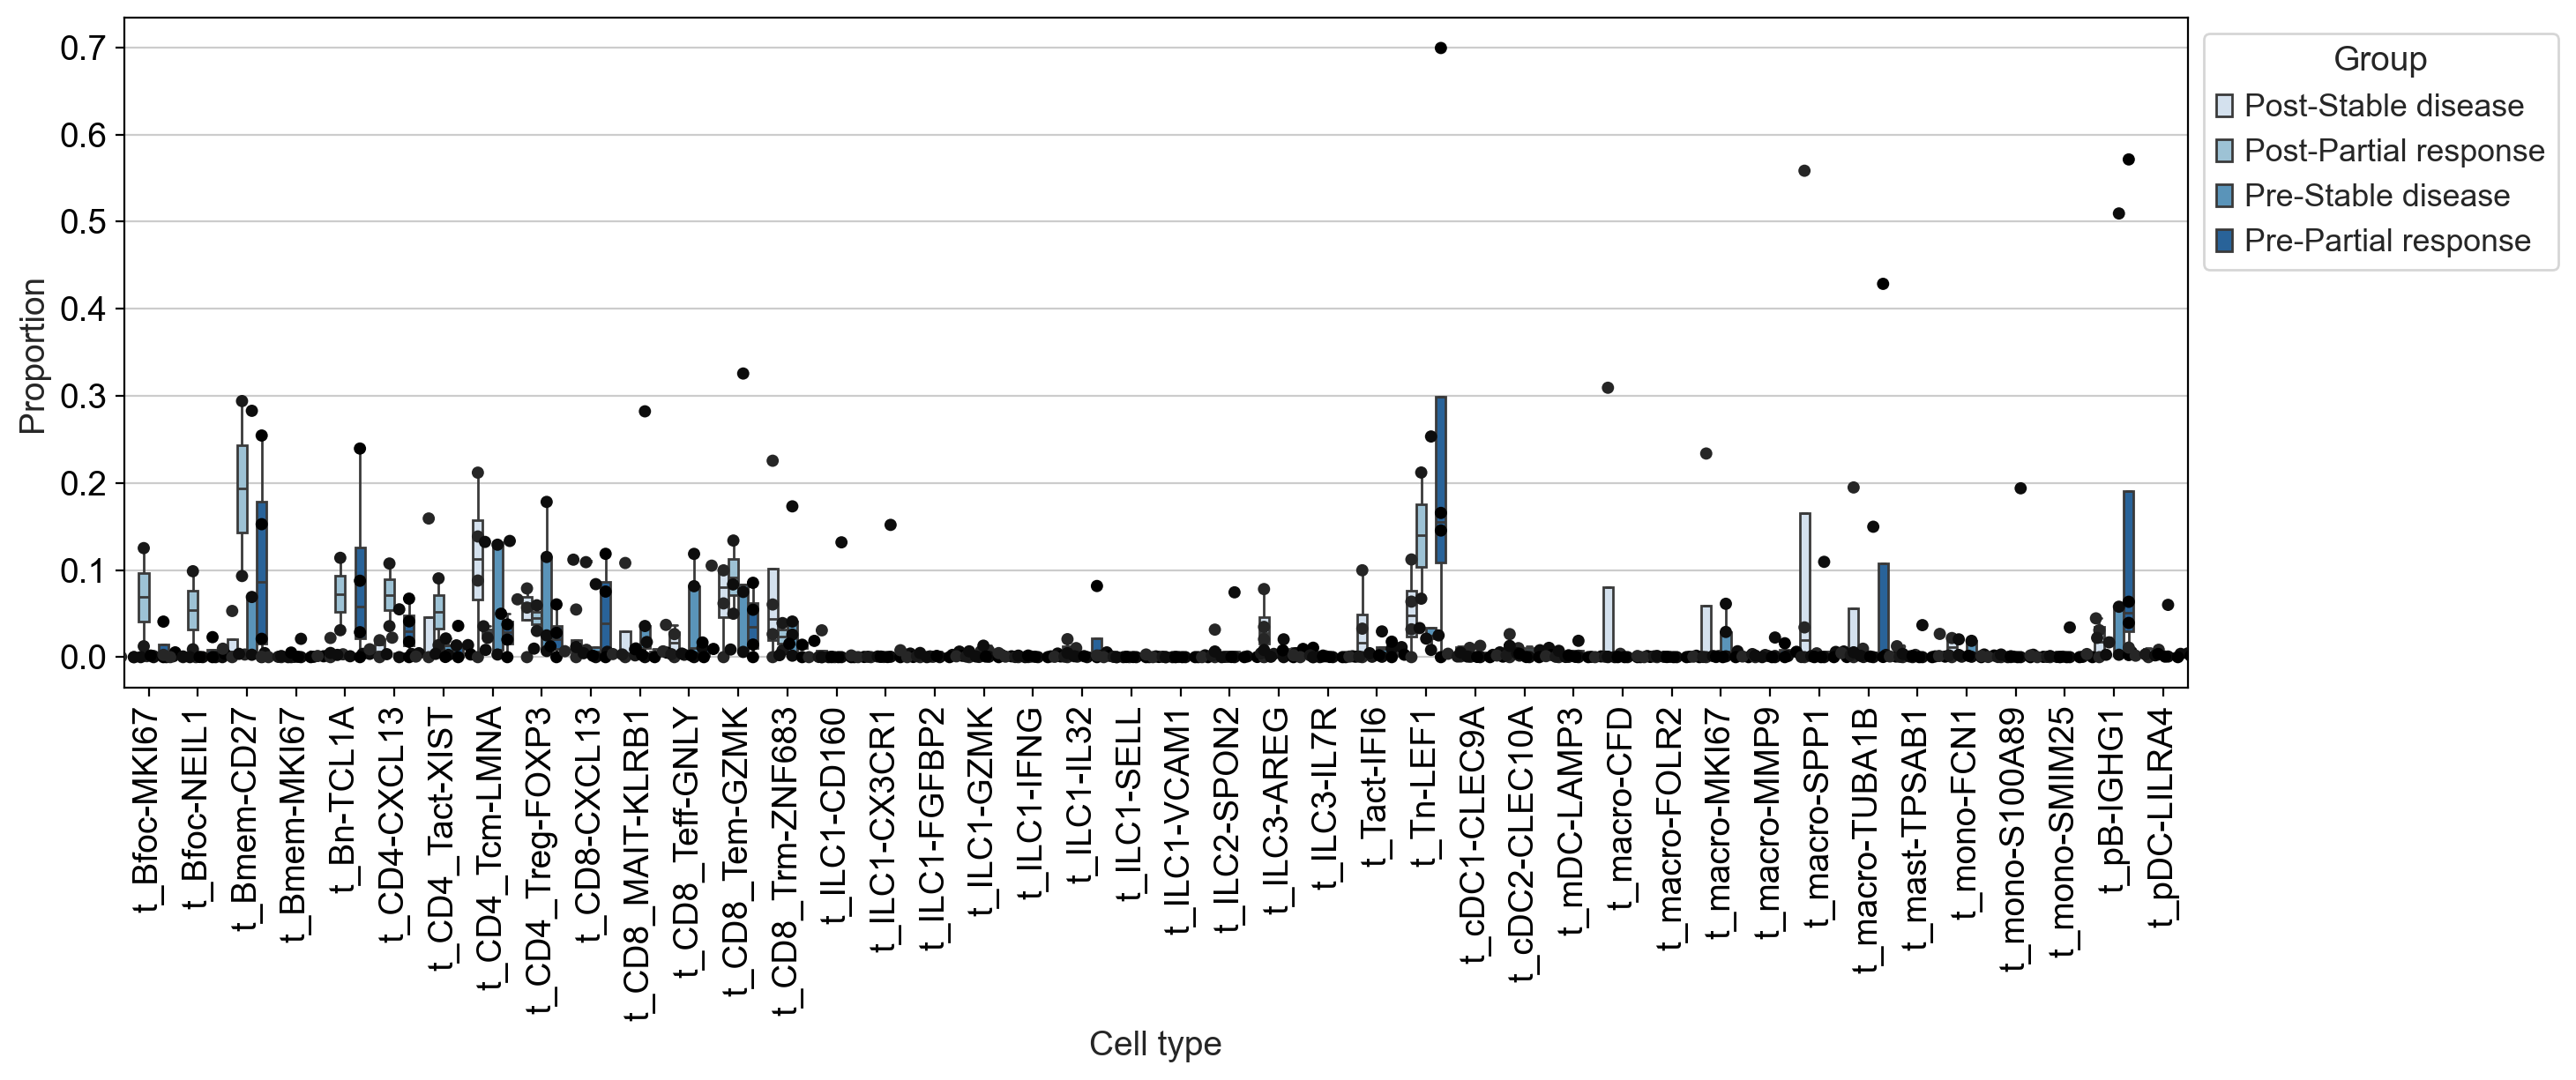

In [117]:
credible_effects_chemo_pdl1 = pd.DataFrame({"log2-fold change": [], "Cell Type": [], "Reference": [], "Comp. Group": [], "Final Parameter": []})

for reference in adata_chemo_pdl1.obs["Group"].unique():
    print(reference)
    sccoda_chemo_pdl1 = run_sccoda(adata_chemo_pdl1, condition="Anti-PD-L1+Chemo", reference=reference, plot=True)
    credible_effects_chemo_pdl1 = pd.concat([credible_effects_chemo_pdl1, sccoda_chemo_pdl1])
credible_effects_chemo_pdl1

# Plotting

In [110]:
group_palette = {
    "Pre-Stable disease": common_config.pt_orange,
    "Pre-Partial response": "lightblue",
    "Post-Stable disease": common_config.pt_red,
    "Post-Partial response": common_config.pt_blue,
}

## Chemo

In [111]:
chemo_cell_types = credible_effects_chemo["Cell Type"].unique()
chemo_cell_types

array(['t_CD4_Tcm-LMNA', 't_CD8_Tem-GZMK', 't_CD8_Trm-ZNF683',
       't_Tn-LEF1'], dtype=object)

In [112]:
fig = plt.subplots(1, len(chemo_cell_types), figsize=(12, 4))

groups = adata_chemo.obs["Group"].unique()
for i, cell_type in enumerate(chemo_cell_types):
    ax = plt.subplot(1, len(chemo_cell_types), i+1)
    
    plot_df = pd.DataFrame({"Proportion": [], "Group": []})
    for group in groups:
        proportions = adata_chemo[adata_chemo.obs["Group"] == group].obs.groupby("Sample")["Cluster"].value_counts(normalize=True)
        plot_df = pd.concat([plot_df, pd.DataFrame({"Proportion": proportions[np.in1d(proportions.index.get_level_values(1), [cell_type])].values, "Group": group})])
    
    sns.boxplot(
        data=plot_df,
        x="Group",
        y="Proportion",
        palette=group_palette,
        ax=ax,
    )
    
    sns.stripplot(
        data=plot_df,
        x="Group",
        y="Proportion",
        palette=group_palette,
        ax=ax,
        edgecolor="black",
        linewidth=0.5,
    )
    
    ax.set_title(cell_type, rotation=45)
    if i != 0:
        ax.set_ylabel("")

    ax.set_xticks([])
    ax.set_xlabel("")
    ax.set_xticklabels([])
    
    ylim = ax.get_ylim()
    ax.set_ylim(ylim[0], ylim[1] + 0.2*ylim[1])

plt.subplots_adjust(wspace=0.5)

markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in group_palette.values()]
plt.legend(markers, group_palette.keys(), title="Group", loc="upper left", bbox_to_anchor=(1, 1))

plt.savefig("figures/compositional_boxplot_chemo.png", bbox_inches="tight")
plt.close()

In [113]:
credible_effects_chemo

log2-fold change         Cell Type              Reference  \
t_CD4_Tcm-LMNA           -1.051869    t_CD4_Tcm-LMNA     Pre-Stable disease   
t_CD8_Tem-GZMK           -1.173683    t_CD8_Tem-GZMK     Pre-Stable disease   
t_CD8_Trm-ZNF683         -0.737895  t_CD8_Trm-ZNF683     Pre-Stable disease   
t_Tn-LEF1                -0.577472         t_Tn-LEF1     Pre-Stable disease   
t_CD4_Tcm-LMNA           -1.099619    t_CD4_Tcm-LMNA    Post-Stable disease   
t_CD8_Tem-GZMK           -1.243750    t_CD8_Tem-GZMK    Post-Stable disease   
t_CD8_Trm-ZNF683         -0.768398  t_CD8_Trm-ZNF683    Post-Stable disease   
t_Tn-LEF1                -0.599843         t_Tn-LEF1    Post-Stable disease   
t_CD4_Tcm-LMNA           -1.084423    t_CD4_Tcm-LMNA  Post-Partial response   
t_CD8_Tem-GZMK           -1.210772    t_CD8_Tem-GZMK  Post-Partial response   
t_CD8_Trm-ZNF683         -0.748751  t_CD8_Trm-ZNF683  Post-Partial response   
t_Tn-LEF1                -0.566308         t_Tn-LEF1  Post-Partial response   

                           Comp. Group  Final Parameter  
t_CD4_Tcm-LMNA    Pre-Partial response        -0.963443  
t_CD8_Tem-GZMK    Pre-Partial response        -1.047878  
t_CD8_Trm-ZNF683  Pre-Partial response        -0.745813  
t_Tn-LEF1         Pre-Partial response        -0.634616  
t_CD4_Tcm-LMNA    Pre-Partial response        -1.012419  
t_CD8_Tem-GZMK    Pre-Partial response        -1.112323  
t_CD8_Trm-ZNF683  Pre-Partial response        -0.782834  
t_Tn-LEF1         Pre-Partial response        -0.666001  
t_CD4_Tcm-LMNA    Pre-Partial response        -0.994157  
t_CD8_Tem-GZMK    Pre-Partial response        -1.081735  
t_CD8_Trm-ZNF683  Pre-Partial response        -0.761486  
t_Tn-LEF1         Pre-Partial response        -0.635026

## Anti-PD-L1 + Chemo

In [114]:
chemo_pdl1_cell_types = credible_effects_chemo_pdl1["Cell Type"].unique()
chemo_pdl1_cell_types

array([], dtype=object)

In [115]:
fig = plt.subplots(1, len(chemo_pdl1_cell_types), figsize=(12, 4))

groups = adata_chemo.obs["Group"].unique()
for i, cell_type in enumerate(chemo_pdl1_cell_types):
    ax = plt.subplot(1, len(chemo_pdl1_cell_types), i+1)
    
    plot_df = pd.DataFrame({"Proportion": [], "Group": []})
    for group in groups:
        proportions = adata_chemo_pdl1[adata_chemo_pdl1.obs["Group"] == group].obs.groupby("Sample")["Cluster"].value_counts(normalize=True)
        plot_df = pd.concat([plot_df, pd.DataFrame({"Proportion": proportions[np.in1d(proportions.index.get_level_values(1), [cell_type])].values, "Group": group})])
    
    sns.boxplot(
        data=plot_df,
        x="Group",
        y="Proportion",
        palette=group_palette,
        ax=ax,
    )
    
    sns.stripplot(
        data=plot_df,
        x="Group",
        y="Proportion",
        palette=group_palette,
        ax=ax,
        edgecolor="black",
        linewidth=0.5,
    )
    
    ax.set_title(cell_type, rotation=45)
    if i != 0:
        ax.set_ylabel("")

    ax.set_xticks([])
    ax.set_xlabel("")
    ax.set_xticklabels([])
    
    ylim = ax.get_ylim()
    ax.set_ylim(ylim[0], ylim[1] + 0.2*ylim[1])

plt.subplots_adjust(wspace=0.5)

markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in group_palette.values()]
plt.legend(markers, group_palette.keys(), title="Group", loc="upper left", bbox_to_anchor=(1, 1))

plt.savefig("figures/compositional_boxplot_chemo_anti_pdl1.png", bbox_inches="tight")
plt.close()

ValueError: Number of columns must be a positive integer, not 0

<Figure size 3600x1200 with 0 Axes>